#### Тестрование label propagation на графах с сообществами (SBM)

Метрика качества -- вес максимального паросочетания в двудольном графе "настоящих сообществ" и найденных сообществ, где вес ребра -- количество общих вершин, делённый на количество вершин (максимальное возможное значение).

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import gen_sbm_graph, label_propagation, quality_of_partition, sizes_to_partition 

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


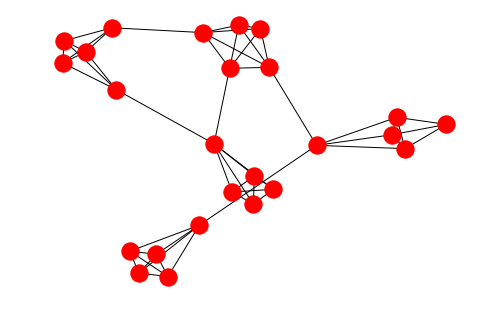

In [2]:
G = gen_sbm_graph([5 for i in range(5)], prob_community=0.97, prob_other=0.03)
nx.draw(G)

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


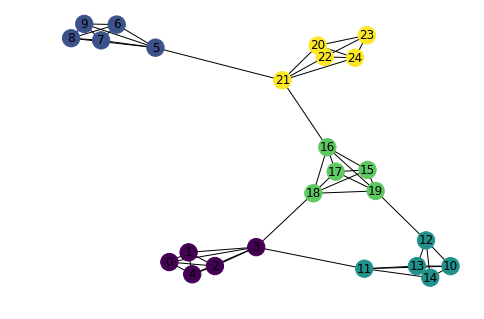

In [3]:
from importlib import reload
import utils
reload(utils)
def draw_partition(graph, partition):
    dct = dict(zip(set(partition), range(len(set(partition)))))
    colors = [dct[i] for i in partition]
    nx.draw(graph, node_color=colors, with_labels=True)
    
partition, deltas = label_propagation(G, min_delta=1)
draw_partition(G, partition)

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


1.0

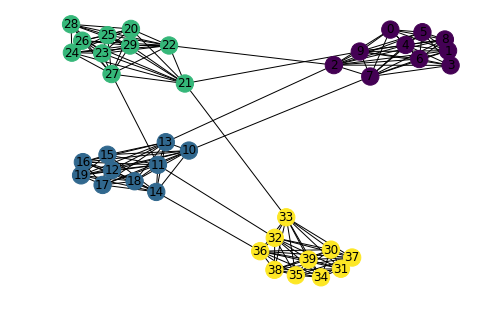

In [4]:
# сгенерировать граф с данными вероятностями и вернуть качество поиска сообществ
def test_quality(sizes, p1, p2, draw=True, min_delta=1):
    true_partition = sizes_to_partition(sizes)
    graph = gen_sbm_graph(sizes, p1, p2)
    partition, _ = label_propagation(graph, min_delta=min_delta)
    if draw: draw_partition(graph, partition)
    return quality_of_partition(true_partition, partition)

test_quality([10 for i in range(4)], 0.98, 0.01)

Зависимость качества от вероятности ребра внутри сообщества и между ними (выбираются как $\alpha$ и $1-\alpha$)

In [5]:
means, devs = [], []
alphas = 2. ** np.arange(-11, -2)
for alpha in alphas:
    results = [test_quality([100 for i in range(20)], p1=1-alpha, p2=alpha, draw=False) for i in range(4)]
    results = np.array(results)
    means.append(results.mean())
    devs.append(results.std())

<ErrorbarContainer object of 3 artists>

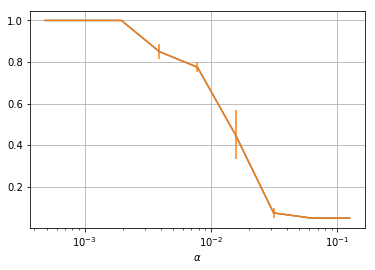

In [6]:
plt.xlabel('$\\alpha$')
plt.xscale('log')
plt.grid(True)
plt.plot(alphas, means)
plt.errorbar(alphas, means, devs)

### Тестирование на датасетах

In [7]:
from utils import parse_6dfb, parse_twitter
from collections import Counter

partition, deltas = label_propagation(parse_6dfb(), max_iter=10**3, min_delta=200)
print(len(deltas), 'iterations')

33 iterations


In [ ]:
plt.title('Сходимость')
plt.plot(deltas)

2 сообщества по 6 тысяч, остальные сообщества довольно небольшие:

In [8]:
Counter(partition).most_common(10)

[(1, 6499),
 (0, 6416),
 (242, 6),
 (809, 4),
 (45, 2),
 (676, 2),
 (702, 2),
 (2, 1),
 (3, 1),
 (4, 1)]

In [9]:
Counter(Counter(partition).values())

Counter({1: 2870, 2: 3, 4: 1, 6: 1, 6416: 1, 6499: 1})

#### Распределение даты рождения в каждой из двух больших компонент и во всех остальных.

In [10]:
years = pd.read_csv('6dfb/SDFB_people.csv')['Extant Birth Year']
years_int = []
for i in years: 
    if len(i) != 4:
        i = i[-4:]
    years_int.append(int(i))
years = np.array(years_int)

partition = np.array(partition)
number_1, number_2 = dict(Counter(partition).most_common(2)).keys()
indexes_1 = (partition == number_1)
indexes_2 = (partition == number_2)
indexes_other = ~(indexes_1 | indexes_2)

(array([  26.,   98.,  188.,  400., 1015., 1319., 1071., 1059., 1010.,
         313.]),
 array([1523. , 1542.2, 1561.4, 1580.6, 1599.8, 1619. , 1638.2, 1657.4,
        1676.6, 1695.8, 1715. ]),
 <a list of 10 Patch objects>)

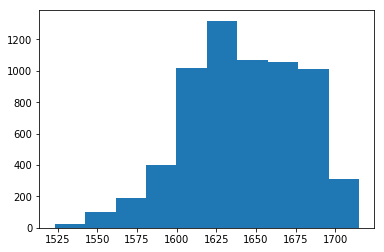

In [11]:
plt.hist(years[indexes_1])

(array([ 103.,  253.,  445.,  687.,  862., 1249., 1505., 1045.,  239.,
          28.]),
 array([1390. , 1417.8, 1445.6, 1473.4, 1501.2, 1529. , 1556.8, 1584.6,
        1612.4, 1640.2, 1668. ]),
 <a list of 10 Patch objects>)

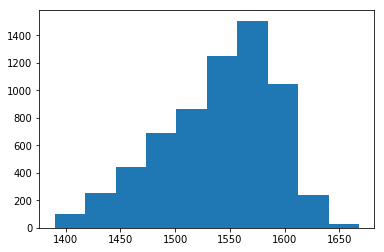

In [12]:
plt.hist(years[indexes_2])

(array([139., 314., 399., 507., 423., 380., 258., 126., 114., 226.]),
 array([1389. , 1420.1, 1451.2, 1482.3, 1513.4, 1544.5, 1575.6, 1606.7,
        1637.8, 1668.9, 1700. ]),
 <a list of 10 Patch objects>)

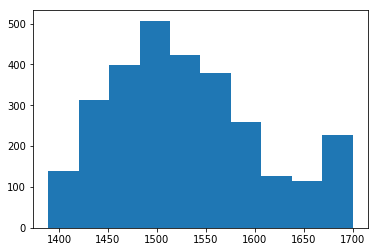

In [13]:
plt.hist(years[indexes_other])

Аналогично для твиттера

In [2]:
from utils import parse_twitter
graph = parse_twitter()

In [ ]:
%%time
partition, deltas = label_propagation(graph, max_iter=250, min_delta= 20 * 1000)
print(len(deltas), 'iterations')

In [ ]:
plt.title('Сходимость')
plt.plot(deltas)

In [ ]:
Counter(partition).most_common()